In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sehriyarmemmedli/facecropped-glasses-vs-noglasses-dataset")

print("Path to dataset files:", path)

100%|██████████| 835M/835M [00:09<00:00, 92.4MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/sehriyarmemmedli/facecropped-glasses-vs-noglasses-dataset/versions/1


In [2]:
# Imports y setup
import os
from pathlib import Path
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Versión de TF
print("TensorFlow:", tf.__version__)

# Semilla para reproducibilidad
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# Path del kaggle
DATA_DIR = Path(path)
print("DATA_DIR:", DATA_DIR)

# Comprobamos que exista
assert DATA_DIR.exists(), "No encuentro el directorio del dataset"

TensorFlow: 2.19.0
DATA_DIR: /root/.cache/kagglehub/datasets/sehriyarmemmedli/facecropped-glasses-vs-noglasses-dataset/versions/1


In [3]:
# Conteo por split (train/validation/test) y por clase
from pathlib import Path

train_dir = DATA_DIR / "train"
val_dir   = DATA_DIR / "val"
test_dir  = DATA_DIR / "test"

assert train_dir.exists(), "No se encontró la carpeta 'train/'."
assert val_dir.exists(),   "No se encontró la carpeta 'val/'."
assert test_dir.exists(),  "No se encontró la carpeta 'test/'."

IMG_EXTS = {".jpg", ".jpeg", ".png"}

def count_images_in_subdirs(root: Path):
    counts = {}
    for sub in sorted([d for d in root.iterdir() if d.is_dir()]):
        n = sum(1 for p in sub.rglob("*") if p.suffix.lower() in IMG_EXTS)
        counts[sub.name] = n
    total = sum(counts.values())
    return counts, total

def print_split_counts(name, dirpath):
    cls_counts, total = count_images_in_subdirs(dirpath)
    print(f"{name}: total={total}")
    for cls, n in cls_counts.items():
        print(f"  - {cls}: {n}")
    return cls_counts, total

print("=== Conteos por split ===")
train_counts, train_total = print_split_counts("train", train_dir)
val_counts,   val_total   = print_split_counts("validation", val_dir)
test_counts,  test_total  = print_split_counts("test", test_dir)


=== Conteos por split ===
train: total=76049
  - with_glasses: 27513
  - without_glasses: 48536
validation: total=15210
  - with_glasses: 5503
  - without_glasses: 9707
test: total=3803
  - with_glasses: 1376
  - without_glasses: 2427


Found 76049 files belonging to 2 classes.
Found 15210 files belonging to 2 classes.
Found 3803 files belonging to 2 classes.
Clases detectadas: ['with_glasses', 'without_glasses']


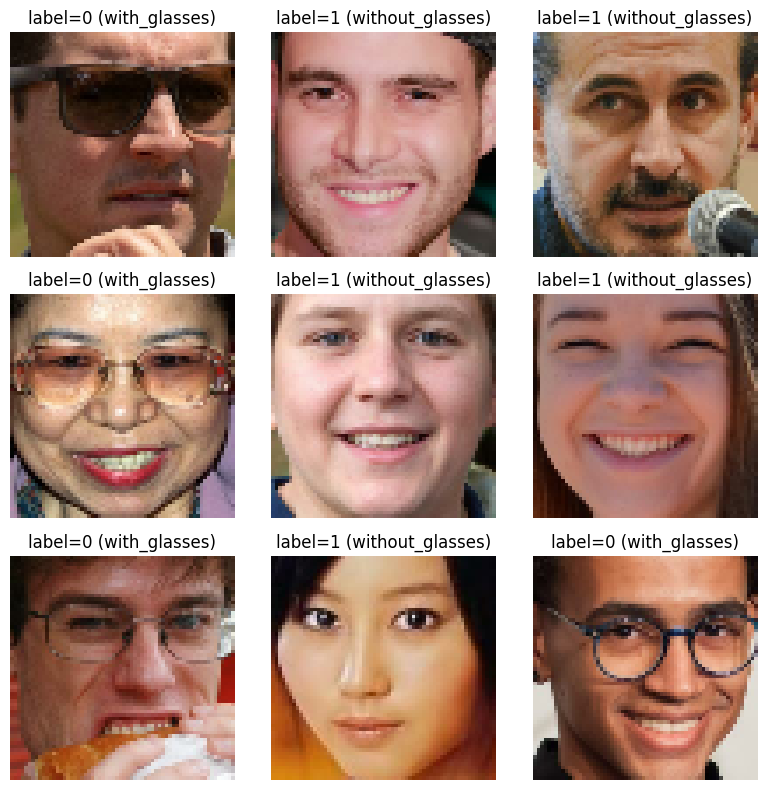

In [4]:
import tensorflow as tf
import matplotlib.pyplot as plt

IMG_SIZE   = (64, 64)
BATCH_SIZE = 32
AUTOTUNE   = tf.data.AUTOTUNE

def make_ds(dirpath, shuffle, batch_size=BATCH_SIZE, img_size=IMG_SIZE):
    return tf.keras.utils.image_dataset_from_directory(
        directory=dirpath,
        labels="inferred",
        label_mode="binary",
        color_mode="rgb",
        image_size=img_size,
        batch_size=batch_size,
        shuffle=shuffle,
        seed=SEED
    )

train_ds = make_ds(train_dir, shuffle=True)
val_ds   = make_ds(val_dir,   shuffle=False)
test_ds  = make_ds(test_dir,  shuffle=False)

class_names = train_ds.class_names
print("Clases detectadas:", class_names)

train_ds = train_ds.cache().shuffle(1000).prefetch(AUTOTUNE)
val_ds   = val_ds.cache().prefetch(AUTOTUNE)
test_ds  = test_ds.cache().prefetch(AUTOTUNE)

# Vista de un batch
plt.figure(figsize=(8, 8))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        lbl = int(labels[i].numpy()[0])
        plt.title(f"label={lbl} ({class_names[lbl]})")
        plt.axis("off")
plt.tight_layout()
plt.show()


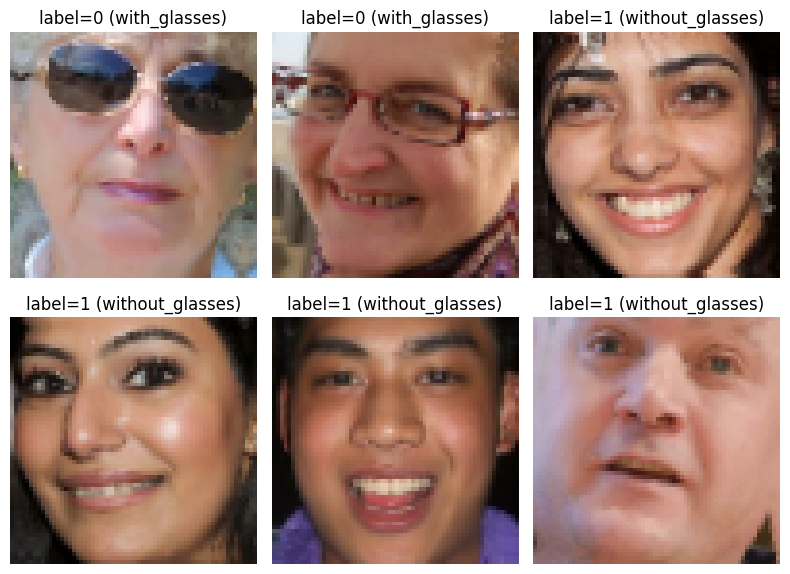

In [5]:
from tensorflow.keras import layers

# Normalización a [0,1]
normalization = layers.Rescaling(1./255)

# Aumentos ligeros(flip y rotación pequeña)
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal", seed=SEED),
    layers.RandomRotation(0.05, seed=SEED),
], name="data_augmentation")

# Aplicar normalización a los datasets
def with_normalization(ds):
    return ds.map(lambda x, y: (normalization(x), y), num_parallel_calls=AUTOTUNE)

train_ds_norm = with_normalization(train_ds)
val_ds_norm   = with_normalization(val_ds)
test_ds_norm  = with_normalization(test_ds)

# Verificación rápida (imágenes tras augmentation)
import matplotlib.pyplot as plt

sample_batch = next(iter(train_ds.take(1)))
images_raw, labels_raw = sample_batch

plt.figure(figsize=(8,6))
for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    aug_img = data_augmentation(images_raw)[i].numpy()
    plt.imshow(aug_img.astype("uint8"))
    plt.title(f"label={int(labels_raw[i].numpy()[0])} ({class_names[int(labels_raw[i].numpy()[0])]})")
    plt.axis("off")
plt.tight_layout()
plt.show()


In [7]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import Sequential

INPUT_SHAPE = IMG_SIZE + (3,)  # (64, 64, 3)

# Cargamos MobileNetV2 pre-entrenada como extractor de características
base_model = MobileNetV2(
    input_shape=INPUT_SHAPE,
    include_top=False,
    weights="imagenet"
)

# Congelamos sus pesos al inicio (solo entrenamos la parte densa)
base_model.trainable = False

def build_mobilenet_model():
    model = Sequential([
        Input(shape=INPUT_SHAPE),

        # Usamos TU augmentation
        data_augmentation,

        # Pasamos por la red pre-entrenada
        base_model,

        GlobalAveragePooling2D(),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')  # salida binaria
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-4),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

model = build_mobilenet_model()
model.summary()

# Callbacks para el entrenamiento
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    verbose=1
)

# OJO: nuevo nombre de checkpoint para no pisar el de la CNN
checkpoint_path = "best_mobilenet_glasses.keras"
checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)


/tmp/ipython-input-1615926152.py:9: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)  │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 2, 2, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/5
2376/2377 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8413 - loss: 0.3538
Epoch 1: val_loss improved from inf to 0.18051, saving model to best_mobilenet_glasses.keras
2377/2377 ━━━━━━━━━━━━━━━━━━━━ 102s 35ms/step - accuracy: 0.8413 - loss: 0.3538 - val_accuracy: 0.9307 - val_loss: 0.1805 - learning_rate: 1.0000e-04
Epoch 2/5
2374/2377 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8977 - loss: 0.2476
Epoch 2: val_loss improved from 0.18051 to 0.16603, saving model to best_mobilenet_glasses.keras
2377/2377 ━━━━━━━━━━━━━━━━━━━━ 33s 14ms/step - accuracy: 0.8977 - loss: 0.2476 - val_accuracy: 0.9362 - val_loss: 0.1660 - learning_rate: 1.0000e-04
Epoch 3/5
2375/2377 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9009 - loss: 0.2362
Epoch 3: val_loss improved from 0.16603 to 0.16396, saving model to best_mobilenet_glasses.keras
2377/2377 ━━━━━━━━━━━━━━━━━━━━ 44s 15ms/step - accuracy: 0.9009 - loss: 0.2362 - val_accuracy: 0.9351 - val_loss: 0.1640 - learning_rate: 1.0000e-04
E

,accuracy,loss,val_accuracy,val_loss,learning_rate
0,0.872595,0.299129,0.930703,0.180508,0.0001
1,0.898947,0.245163,0.936226,0.166031,0.0001
2,0.901918,0.233782,0.935108,0.163960,0.0001
3,0.908217,0.223895,0.941091,0.154682,0.0001
4,0.908769,0.219360,0.940434,0.156360,0.0001


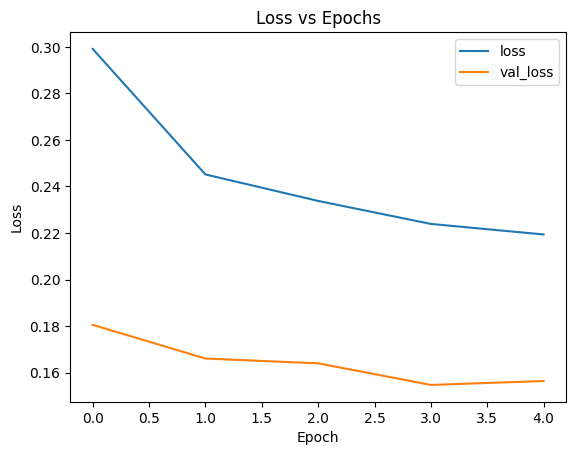

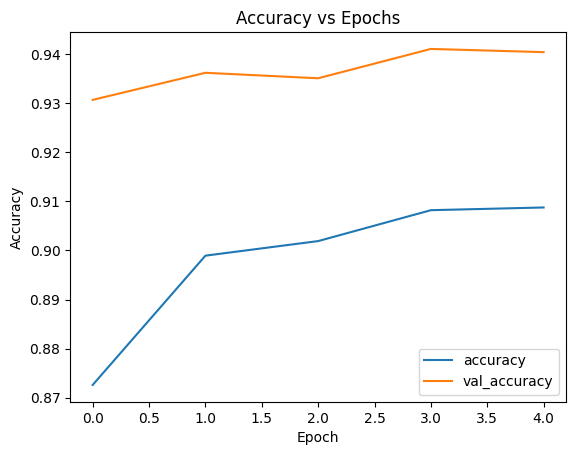

Best model loaded from: best_mobilenet_glasses.keras


In [8]:
import pandas as pd
import matplotlib.pyplot as plt

EPOCHS = 5

history = model.fit(
    train_ds_norm,
    validation_data=val_ds_norm,
    epochs=EPOCHS,
    callbacks=[early_stop, reduce_lr, checkpoint],
    verbose=1
)

# History a DataFrame
hist_df = pd.DataFrame(history.history)
display(hist_df.head())

# Gráfica de pérdida
ax = hist_df[['loss','val_loss']].plot(title='Loss vs Epochs')
ax.set_xlabel('Epoch'); ax.set_ylabel('Loss')
plt.show()

# Gráfica de accuracy
ax = hist_df[['accuracy','val_accuracy']].plot(title='Accuracy vs Epochs')
ax.set_xlabel('Epoch'); ax.set_ylabel('Accuracy')
plt.show()

# Cargar el mejor checkpoint
best_model = tf.keras.models.load_model(checkpoint_path)
print("Best model loaded from:", checkpoint_path)

119/119 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.9105 - loss: 0.2191
Test loss: 0.1477
Test accuracy: 0.9458


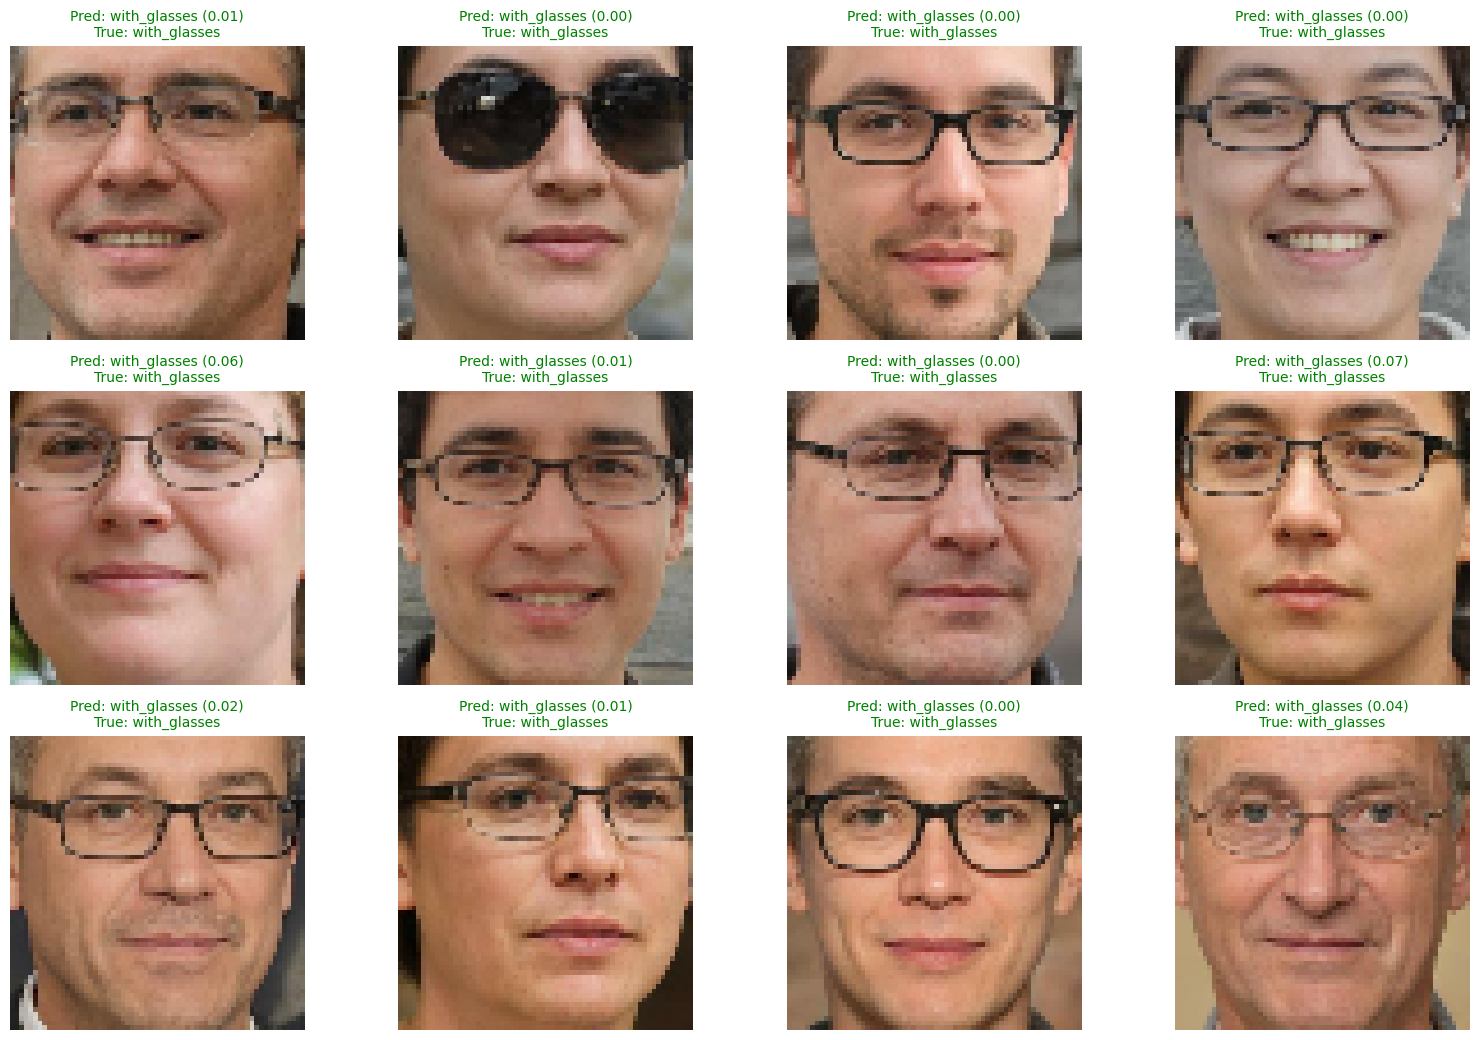

In [9]:
# Evaluación y visualización de predicciones
import numpy as np
import matplotlib.pyplot as plt

# Evaluación
test_loss, test_acc = best_model.evaluate(test_ds_norm, verbose=1)
print(f"Test loss: {test_loss:.4f}")
print(f"Test accuracy: {test_acc:.4f}")

# Función para mostrar N predicciones del test
def show_test_predictions(model, test_ds, class_names, n=12):
    # Recolectar un batch grande (o varios) para muestreo simple
    images_list, labels_list = [], []
    for images, labels in test_ds.take(2):  # 2 batches
        images_list.append(images)
        labels_list.append(labels)
    images = tf.concat(images_list, axis=0)
    labels = tf.concat(labels_list, axis=0)

    # Predicciones
    probs = model.predict(images, verbose=0).ravel()  # shape (batch,)
    preds = (probs >= 0.5).astype(int)

    # n índices aleatorios
    idxs = np.random.choice(len(images), size=min(n, len(images)), replace=False)

    cols = 4
    rows = int(np.ceil(len(idxs)/cols))
    plt.figure(figsize=(4*cols, 3.5*rows))
    for i, idx in enumerate(idxs):
        plt.subplot(rows, cols, i+1)
        img = images[idx].numpy()
        true_lbl = int(labels[idx].numpy()[0])
        pred_lbl = int(preds[idx])
        conf = probs[idx]

        plt.imshow((img*255).astype("uint8"))  # imágenes ya normalizadas -> a [0,255] para mostrar
        title = f"Pred: {class_names[pred_lbl]} ({conf:.2f})\nTrue: {class_names[true_lbl]}"
        color = "green" if pred_lbl == true_lbl else "red"
        plt.title(title, color=color, fontsize=10)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Mostrar algunas predicciones
show_test_predictions(best_model, test_ds_norm, class_names, n=12)


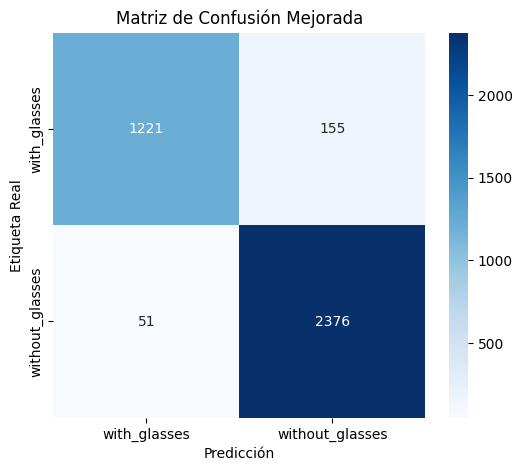

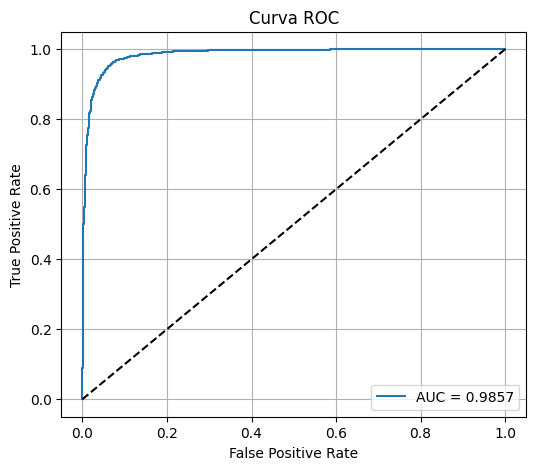

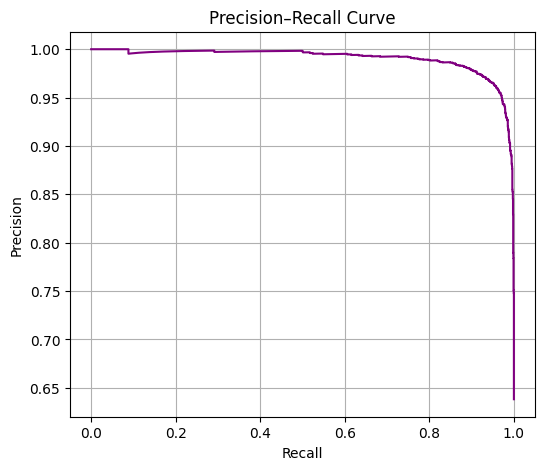

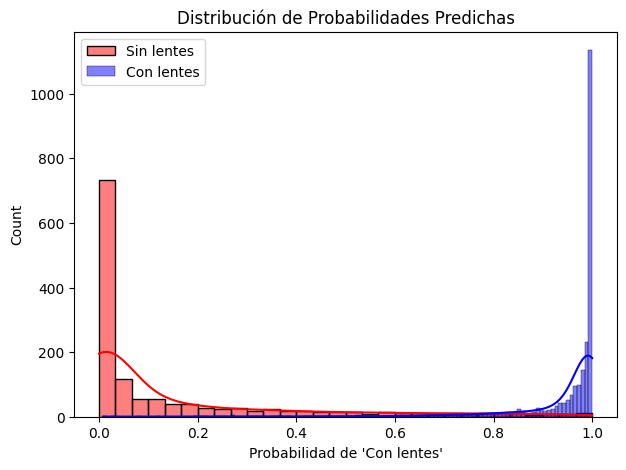

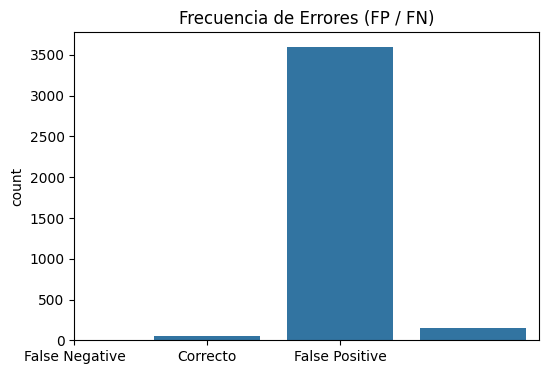

In [10]:
# ===========================================
# MÉTRICAS AVANZADAS
# ===========================================

from sklearn.metrics import (
    roc_curve, auc, precision_recall_curve,
    confusion_matrix, ConfusionMatrixDisplay
)
import seaborn as sns

# Generar predicciones completas
y_true = []
y_probs = []

for images, labels in test_ds_norm:
    probs = best_model.predict(images, verbose=0).ravel()
    y_true.extend(labels.numpy().flatten())
    y_probs.extend(probs)

y_true = np.array(y_true).astype(int)
y_probs = np.array(y_probs)
y_pred = (y_probs >= 0.5).astype(int)

# Matriz de confusión mejorada
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.title("Matriz de Confusión Mejorada")
plt.xlabel("Predicción")
plt.ylabel("Etiqueta Real")
plt.show()


# Curva ROC y AUC
fpr, tpr, _ = roc_curve(y_true, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC")
plt.legend()
plt.grid(True)
plt.show()


# =============================
# Precision–Recall Curve
# =============================
precision, recall, _ = precision_recall_curve(y_true, y_probs)

plt.figure(figsize=(6,5))
plt.plot(recall, precision, color="purple")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.grid(True)
plt.show()

# Distribución de probabilidades
plt.figure(figsize=(7,5))
sns.histplot(y_probs[y_true==0], color="red", label="Sin lentes", kde=True)
sns.histplot(y_probs[y_true==1], color="blue", label="Con lentes", kde=True)
plt.title("Distribución de Probabilidades Predichas")
plt.xlabel("Probabilidad de 'Con lentes'")
plt.legend()
plt.show()


# Errores: FP y FN
errors = y_pred - y_true  # 1→FP, -1→FN, 0→correcto

plt.figure(figsize=(6,4))
sns.countplot(x=errors)
plt.title("Frecuencia de Errores (FP / FN)")
plt.xticks([-1, 0, 1], ["False Negative", "Correcto", "False Positive"])
plt.show()


In [12]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

save_path = "/content/drive/MyDrive/glasses_classifier/best_mobilenet_glasses.keras"
!mkdir -p "/content/drive/MyDrive/glasses_classifier"

best_model.save(save_path)
print(" Modelo guardado en:", save_path)

Mounted at /content/drive
 Modelo guardado en: /content/drive/MyDrive/glasses_classifier/best_mobilenet_glasses.keras
